<font size=4, color=Red>Version 1</font><br>
Previous info:  CV: 40.6601, LB: 40.49519, TIME CONSUME: about 27500s for 750epochs.<br> 
Version 1: Add gaussian noise.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage.util import random_noise
import xml.etree.ElementTree as ET

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader,Dataset

from tqdm import tqdm_notebook as tqdm

In [2]:
def seed_everything(seed=19960720):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
def summary(model, input_size, batch_size=-1, device="cuda"):

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    # return summary

# Generator and Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
#                 nn.LeakyReLU(0.2, inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 64, 3, 1, 1),
            *convlayer(64, 128, 4, 2, 1),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            *convlayer(256, 512, 4, 2, 1, bn=True),
            *convlayer(512, 1024, 4, 2, 1, bn=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )
        
    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Data Cleaning

In [6]:
import glob
image = glob.glob('../input/all-dogs/all-dogs/*')
breed = glob.glob('../input/annotation/Annotation/*')
annot = glob.glob('../input/annotation/Annotation/*/*')
print(len(image), len(breed), len(annot))

20579 120 20580


In [7]:
def get_bbox(annot):
    
    """
    This extracts and returns values of bounding boxes
    """
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

In [8]:
def get_image(annot):
    """
    Retrieve the corresponding image given annotation file
    """
    img_path = '../input/all-dogs/all-dogs/'
    file = annot.split('/')
    img_class = file[-2]
    img_filename = img_path+file[-1]+'.jpg'
    return img_filename, img_class

In [9]:
select_dogs = []
select_bbox = []

In [10]:
def get_class_dict(breed):
    class_dict = {}
    for i in range(len(breed)):
        class_ = breed[i].split('/')
        class_dict[class_[-1]] = i
    return class_dict

class_dict = get_class_dict(breed)

In [11]:
def get_cleaned_data(image, annot, class_dict):
    select_dogs = []
    select_bbox = []
    select_labels = []
    
    for i in range(len(image)):
        bbox = get_bbox(annot[i])
        bbox = bbox[0]

        dog, dog_class = get_image(annot[i])
        if dog == '../input/all-dogs/all-dogs/n02105855_2933.jpg':   # this jpg is not in the dataset
            continue
        im = Image.open(dog)
        
        xdiff = abs(bbox[2] - bbox[0])
        ydiff = abs(bbox[3] - bbox[1])
        
        if ((abs(ydiff - xdiff)/min(ydiff, xdiff)<=0.5) and ((xdiff>=64) and (ydiff>=64))):
#         if (0.8<(ydiff/xdiff)<1.25) and (min(xdiff, ydiff)>=128):            
            select_dogs.append(dog)
            select_bbox.append(bbox)
            select_labels.append(class_dict[dog_class])
            
    return select_dogs, select_bbox, select_labels

select_dogs, select_bbox, select_labels = get_cleaned_data(image, annot, class_dict)

In [12]:
print(len(select_dogs), len(select_bbox), len(select_labels))

15007 15007 15007


In [13]:
print(select_bbox[0])

(53, 118, 330, 483)


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder

def prepare_labels(y):
    values = np.array(y)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_encoded = onehot_encoder.fit_transform(values.reshape(values.shape[0], 1))
    y = onehot_encoded
    return y

labels_encoded = prepare_labels(select_labels)

# Data Loader

In [15]:
from PIL import Image
from skimage import util

In [16]:
class dogs_Dataset(Dataset):
    def __init__(self, datafolder, datatype='train', index=[], \
                 transform = transforms.Compose([transforms.RandomResizedCrop(128),transforms.ToTensor()])):

        self.datafolder = datafolder
        self.datatype = datatype
        
        self.image_files_list = [select_dogs[i] for i in index]
        self.bbox_list = [select_bbox[i] for i in index]
        self.label_list = [labels_encoded[i] for i in index]
        
        self.transform = transform
        
        self.imgs = []
        
        for idx in range(len(self.image_files_list)):
            img_name = self.image_files_list[idx]
            bbox = self.bbox_list[idx]
#             print(bbox)
#             img = Image.open(img_name)
            img = cv2.imread(img_name, 1)[bbox[1]:bbox[3], bbox[0]:bbox[2]]
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img = img.crop(bbox)
#             img = np.asarray(img, dtype=float)
#             img = np.array(img)
#             img = util.random_noise(img,mode='gaussian')
            mean, var = 0, 0.01
            noise = np.random.normal(mean, var ** 0.5, img.shape)
            out = img + noise
            if out.min() < 0:
                low_clip = -1.
            else:
                low_clip = 0.
            out = np.clip(out, low_clip, 1.0)
            out = np.uint8(out*255)
            image = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#             print(type(image), np.max(img))
            self.imgs.append(image)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        
        image = self.imgs[idx]
        image = self.transform(image)

        if self.datatype == 'train':
            label = self.label_list[idx]
        else:
            label = torch.zeros(1)
        return image, label

In [17]:
batch_size = 32
image_size = 64


transform = transforms.Compose([transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
#                                 transforms.Resize(image_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_idx = [i for i in range(len(select_dogs))]
train_data = dogs_Dataset('../input/all-dogs/all-dogs/', index=train_idx, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size, num_workers=4)


In [18]:
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

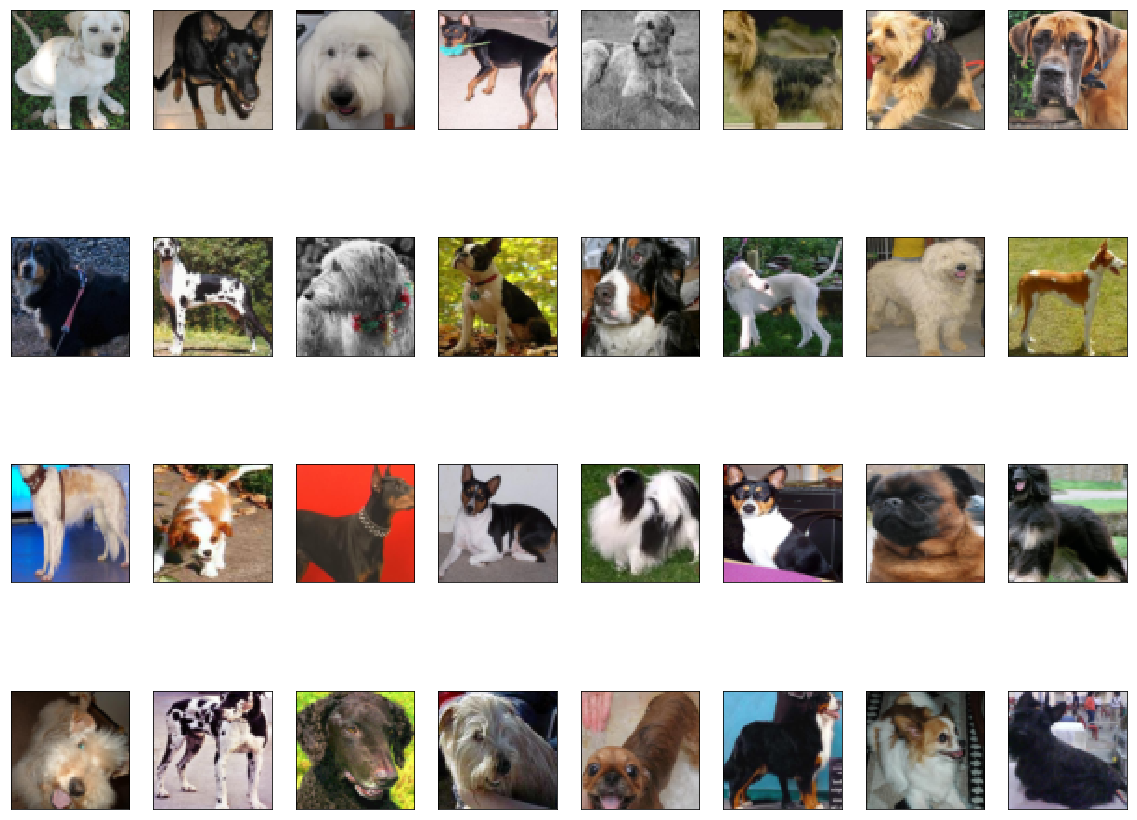

In [19]:
fig = plt.figure(figsize=(20, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii +1, xticks=[], yticks=[])
    plt.imshow( (img+1.)/2. )

## Parameters of GAN

In [20]:
LR_G = 0.0005
LR_D = 0.0005

beta1 = 0.5

real_label = 0.8
fake_label = 0.0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initialize models and optimizers

In [21]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

In [22]:
summary(netG, (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       2,097,152
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [23]:
summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
         LeakyReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 16, 16]         524,288
       BatchNorm2d-6          [-1, 256, 16, 16]             512
         LeakyReLU-7          [-1, 256, 16, 16]               0
            Conv2d-8            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
        LeakyReLU-10            [-1, 512, 8, 8]               0
           Conv2d-11           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-12           [-1, 1024, 4, 4]           2,048
        LeakyReLU-13           [-1, 1024, 4, 4]               0
           Conv2d-14              [-1, 

In [24]:
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.imshow(gen_image)
    plt.show()

## Training loop

In [25]:
epochs = 600

In [26]:
for epoch in range(epochs):
    for ii, (real_images, train_labels) in enumerate(train_loader):

#         real_label = np.random.uniform(0.7, 0.9)
        
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
#             valid_image = netG(fixed_noise)

OSError: [Errno 12] Cannot allocate memory

## Generated results 

In [27]:
from scipy.stats import truncnorm
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

In [28]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = netG(gen_z).to("cpu").clone().detach()
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

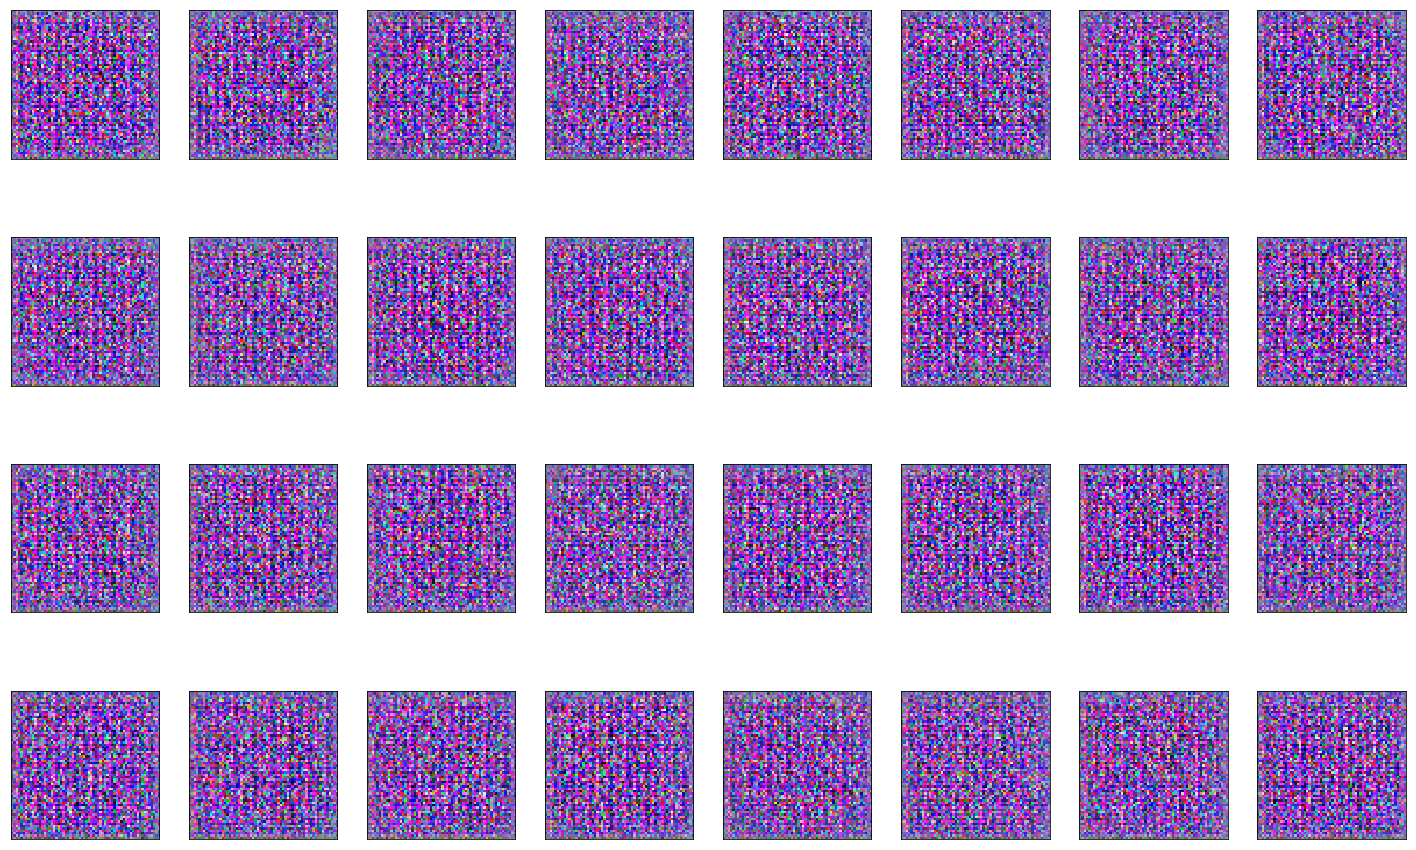

In [29]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

## Make predictions and submit

In [30]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
    
im_batch_size = 50
n_images=10000

for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)
#     gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z)+1.)/2.
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'